# 웹 스크래핑 미니 프로젝트*
1) 스크랩 대상
- 다음, 네이버 등 포털사이트 (지식인 등)
- 국내/국외 언론사
- 영화 평론 (네이버, 다음, IMDB, 넷플릭스 등)
- 쇼핑몰 상품 정보 (다나와, 보배드림 등)
2) 산출물
- 스크래핑 한 데이터를 특징별(ex영화의 경우, 평점, 작성일, 좋아요, 나빠요 등)로 저장(리스트 or 데이터프레임)
- 빈도수 등 간단한 통계 분석

참고사항 : 스크래핑을 수행할 수 없도록 사이트 자체에서 막아놨을 수도 있습니다.
이런 경우에는 다른 사이트를 참조하세요

In [218]:
from selenium import webdriver
from bs4 import BeautifulSoup
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re


# 한글 깨짐 방지 코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [219]:
driver = webdriver.Chrome('e:\chromedriver')

In [220]:
driver.get('http://prod.danawa.com/list/?cate=112758&15main_11_02')
time.sleep(2)

In [221]:

notebook_name=[]
notebook_content=[]
notebook_date=[]
notebook_review=[]
notebook_review_count=[]
price_list=[]
total=[]
missing_content=0
missing_review=0

for z in range(10): #한 페이지에 30개 제품씩 10번 * 10번 = 3000개의 제품 분석 # => text할때는 1로. 최종은 10으로
    for j in range(2,11):

        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')

        for i in range(len(soup.select('div > div.prod_info > p > a'))-1):
            name = soup.select('div > div.prod_info > p > a')[i].text.strip()
            notebook_name.append(name)
            #productItem14352785 > div > div.prod_info > p > a

            #productItem11781655 > div > div.prod_info > dl > dd > div
            try:
                content = soup.select('div.prod_info > dl > dd > div')[i].text.strip()
            #productItem11781655 > div > div.prod_info > dl > dd > div
            #adReaderProductItem11781655 > div > div.prod_info > dl > dd > ul > li
                notebook_content.append(content)

                content_list = content.split(" / ")
                for contents in content_list:
                    total.append(contents)

                date = soup.select('div > dl.meta_item.mt_date > dd')[i].text
                notebook_date.append(date)

            except:
                notebook_content.append(' ')
                missing_content+=1

            try:
                review = soup.select('dl.meta_item.mt_comment > dd > a > strong')[i].text +'건'
                notebook_review.append(review)
                review_count = soup.select('dl.meta_item.mt_comment > dd > a > strong')[i].text
                review_count = int(review_count.replace("," ,""))
                notebook_review_count.append(review_count)

            except:
                notebook_review.append('0건')
                missing_review+=1

        for t in range(len(soup.select('p.memory_sect'))):
            price = soup.select('p.memory_sect')[t].text.strip() + ' : ' +  soup.select('p.price_sect > a')[t].text.strip() 
            price_list.append(price)

        if j % 10 != 0:    
            right = driver.find_element_by_css_selector('div.prod_num_nav > div > div > a:nth-of-type({})'.format(j))
            right.click()
            time.sleep(2) 
        else:
            next_page = driver.find_element_by_css_selector('div.prod_num_nav > div > a.edge_nav.nav_next')
            next_page.click()
            time.sleep(3) 
    #productListArea > div.prod_num_nav > div > div > a.num.now_on
    #productListArea > div.prod_num_nav > div > div > a.num.now_on
    #productListArea > div.prod_num_nav > div > div > a.num.now_on


print('내용 결측치 수 : {}\n리뷰 결측치 수: {}'.format(missing_content, missing_review))

내용 결측치 수 : 4
리뷰 결측치 수: 732


In [222]:
data=[notebook_name, notebook_content, notebook_date, notebook_review]
data
df = pd.DataFrame(data)
df = df.transpose()
df.rename(columns=df.iloc[0], inplace=True)

df.columns=['노트북이름', '노트북정보', '등록월', '리뷰건수']

df

,노트북이름,노트북정보,등록월,리뷰건수
0,LG전자 2021 그램15 15ZD90P-GX50K (SSD 256GB),39.62cm(15.6인치) / 인텔 / 코어i5-10세대 / 코멧레이크 / i5-...,2021.05,63건
1,MSI GF시리즈 GF65 Thin 9SEXR (SSD 512GB),39.6cm(15.6인치) / AMD / 라이젠5-4세대 / 세잔 / 5600H (...,2020.05,212건
2,ASUS 젠북 UM425QA-KI064 (SSD 512GB),43.94cm(17.3인치) / AMD / 라이젠9-4세대 / 세잔 / 5900HX...,2021.07,14건
3,MSI GF시리즈 Sword GF66 A11UE 블랙 (SSD 512GB),39.62cm(15.6인치) / AMD / 라이젠5-4세대 / 루시엔 / 5500U...,2021.07,"2,131건"
4,삼성전자 노트북 NT350XCR-AD5WA,39.62cm(15.6인치) / 인텔 / 코어i5-11세대 / 타이거레이크 / i5...,2020.07,30건
...,...,...,...,...
2700,레노버 LEGION 7 16ACHg R7 3070 PRO W10,40.6cm(16인치) / AMD / 라이젠7-4세대 / 세잔 / 5800H (3....,2019.08,0건
2701,APPLE 2020 맥북프로13 MYDC2KH/A,33.78cm(13.3인치) / 애플(ARM) / 실리콘 M1 / 파이어스톰 / A...,None,0건
2702,HP 오멘 15-en1041AX 32GB램,39.62cm(15.6인치) / AMD / 라이젠9-4세대 / 세잔 / 5900HX...,None,0건
2703,DELL 에일리언웨어 M15 R5 WP04KR,39.6cm(15.6인치) / AMD / 라이젠7-4세대 / 세잔 / 5800H (...,None,0건


In [223]:
driver.close()

In [224]:
df.to_excel('notebook.xlsx')

In [225]:
# 출시일 상위 갯수

for i in Counter(notebook_date).most_common(15):
    print(i[0], ': ', i[1],'개 출시')

2021.05 :  454 개 출시
2021.06 :  239 개 출시
2021.04 :  227 개 출시
2020.12 :  202 개 출시
2020.11 :  183 개 출시
2021.07 :  176 개 출시
2021.03 :  145 개 출시
2020.10 :  126 개 출시
2021.01 :  105 개 출시
2020.06 :  103 개 출시
2021.02 :  100 개 출시
2020.07 :  96 개 출시
2020.01 :  79 개 출시
2020.09 :  67 개 출시
2020.05 :  57 개 출시


In [226]:
# 상위 리뷰 갯수

for i in sorted(notebook_review_count, reverse=True)[:15]:
    print('리뷰 :', i, '개')


리뷰 : 2579 개
리뷰 : 2559 개
리뷰 : 2497 개
리뷰 : 2131 개
리뷰 : 2116 개
리뷰 : 1772 개
리뷰 : 1592 개
리뷰 : 1347 개
리뷰 : 1342 개
리뷰 : 1325 개
리뷰 : 1112 개
리뷰 : 1105 개
리뷰 : 1088 개
리뷰 : 1060 개
리뷰 : 945 개


In [227]:
# MSI LG전자 ASUS 레노버 GIGABYTE HP 삼성전자 한성 dell apple 에이서 Razer


msi=[]
lg=[]
asus=[]
lenova=[]
gigabyte=[]
hp=[]
samsung=[]
hansung=[]
dell=[]
apple=[]
acer=[]
razer=[]
e_t_c=[]
total_name=[]


for i in notebook_name:
    if re.match('MSI.*', i):
        msi.append(i)
    elif re.match('LG전자.*', i):
        lg.append(i)
    elif re.match('ASUS.*', i):
        asus.append(i)
    elif re.match('레노버.*', i):
        lenova.append(i)
    elif re.match('GIGABYTE.*', i):
        gigabyte.append(i)
    elif re.match('HP.*', i):
        hp.append(i)
    elif re.match('삼성전자.*', i):
        samsung.append(i)
    elif re.match('한성.*', i):
        hansung.append(i)
    elif re.match('DELL.*', i):
        dell.append(i)    
    elif re.match('APPLE.*', i):
        apple.append(i)   
    elif re.match('에이서.*', i):
        acer.append(i)     
    elif re.match('Razer.*', i):
        razer.append(i)     
    else:
        e_t_c.append(i)

total_name_count=[len(msi), len(lg), len(asus), len(lenova), len(gigabyte), len(hp), len(samsung), len(hansung), len(dell), len(apple), len(e_t_c)]
total_name=['MSI', 'LG전자', 'ASUS', 'LENOVA', 'GIGABYTE', 'HP', '삼성전자', '한성', 'DELL', 'APPLE', '기타']

print('MSI 노트북의 총 제품 수 : ', len(msi))
print('LG전자 노트북의 총 제품 수 : ', len(lg))
print('ASUS 노트북의 총 제품 수 : ', len(asus))
print('LENOVA 노트북의 총 제품 수 : ', len(lenova))
print('GIGABYTE 노트북의 총 제품 수 : ', len(gigabyte))
print('HP 노트북의 총 제품 수 : ', len(hp))
print('삼성전자 노트북의 총 제품 수 : ', len(samsung))
print('한성 노트북의 총 제품 수 : ', len(hansung))
print('DELL 노트북의 총 제품 수 : ', len(dell))
print('APPLE 노트북의 총 제품 수 : ', len(apple))
print('기타 노트북의 총 제품 수 : ', len(e_t_c))

e_t_c

MSI 노트북의 총 제품 수 :  632
LG전자 노트북의 총 제품 수 :  406
ASUS 노트북의 총 제품 수 :  350
LENOVA 노트북의 총 제품 수 :  346
GIGABYTE 노트북의 총 제품 수 :  28
HP 노트북의 총 제품 수 :  262
삼성전자 노트북의 총 제품 수 :  169
한성 노트북의 총 제품 수 :  84
DELL 노트북의 총 제품 수 :  203
APPLE 노트북의 총 제품 수 :  80
기타 노트북의 총 제품 수 :  52


['주연테크 리오나인 L9T36',
 '주연테크 리오나인 L7T36',
 '주연테크 캐리북T J3GP Pro',
 '주연테크 슈퍼플라이 J9FT',
 '주연테크 스튜디오 J11STF_65T',
 '주연테크 캐리북e J3GW',
 '주연테크 스튜디오 J11STU_65T',
 '주연테크 슈퍼플라이 J9ST',
 'ADATA XPG XENIA Xe i5',
 'ADATA XPG XENIA Xe i7',
 '주연테크 캐리북 슈퍼플라이 J7FC_5S',
 '화웨이 메이트북 14',
 'MPGIO ARES11',
 '주연테크 리오나인 L9T27S 300 에디션',
 '주연테크 리오나인 L7T65T I7',
 '주연테크 캐리북e J3GWUP',
 'Microsoft 서피스 랩탑4 15 5UI-00021',
 'Microsoft 서피스 랩탑 고 기업용 21O-00021',
 'Microsoft 서피스 랩탑4 13.5 5PB-00021',
 'TG삼보 노브랜드 NP43C0',
 '디클 클릭북 D15 WIN10',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17',
 '디클 클릭북 D17']

([<matplotlib.patches.Wedge at 0x24e39b33430>,
 [Text(0.607976251750453, -0.9167141742699684, 'MSI'),
  Text(1.062098748469203, 0.2862625516901447, 'LG전자'),
  Text(0.42658157852696604, 1.013917233733327, 'ASUS'),
  Text(-0.4674098878968559, 0.9957549882858979, 'LENOVA'),
  Text(-0.8538790160198404, 0.6934627791028075, 'GIGABYTE'),
  Text(-1.0394659006385196, 0.35987586944632927, 'HP'),
  Text(-1.0812115883369722, -0.20243888274203134, '삼성전자'),
  Text(-0.9708832829156597, -0.5170934644287349, '한성'),
  Text(-0.7386400288404569, -0.8151140458822735, 'DELL'),
  Text(-0.42414139887867874, -1.0149404286741355, 'APPLE'),
  Text(-0.25834778615653686, -1.069231696774846, '기타')],
 [Text(0.33162341004570156, -0.5000259132381645, '24.2%'),
  Text(0.5793265900741107, 0.15614321001280618, '15.5%'),
  Text(0.2326808610147087, 0.553045763854542, '13.4%'),
  Text(-0.25495084794373957, 0.5431390845195806, '13.2%'),
  Text(-0.46575219055627654, 0.3782524249651677, '1.1%'),
  Text(-0.5669814003482834, 0.1

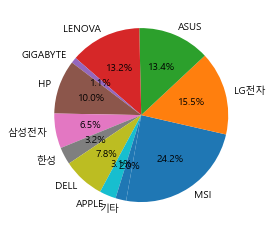

In [228]:
plt.pie(total_name_count, labels=total_name, autopct='%.1f%%', startangle=260, counterclock=True)

In [229]:
notebook_df = pd.DataFrame(Counter(total).most_common(50))
notebook_df.columns=['내용', '언급된 수']

notebook_df

,내용,언급된 수
0,M.2(NVMe),2470
1,웹캠(HD),2214
2,광시야각,2149
3,DDR4,2110
4,슬림형 베젤,2098
5,802.11ax(Wi-Fi 6),2084
6,ㅗ형 방향키,2055
7,인텔,2021
8,1920x1080(FHD),2020
9,충전단자: DC,1943


<AxesSubplot:xlabel='언급된 수', ylabel='내용'>

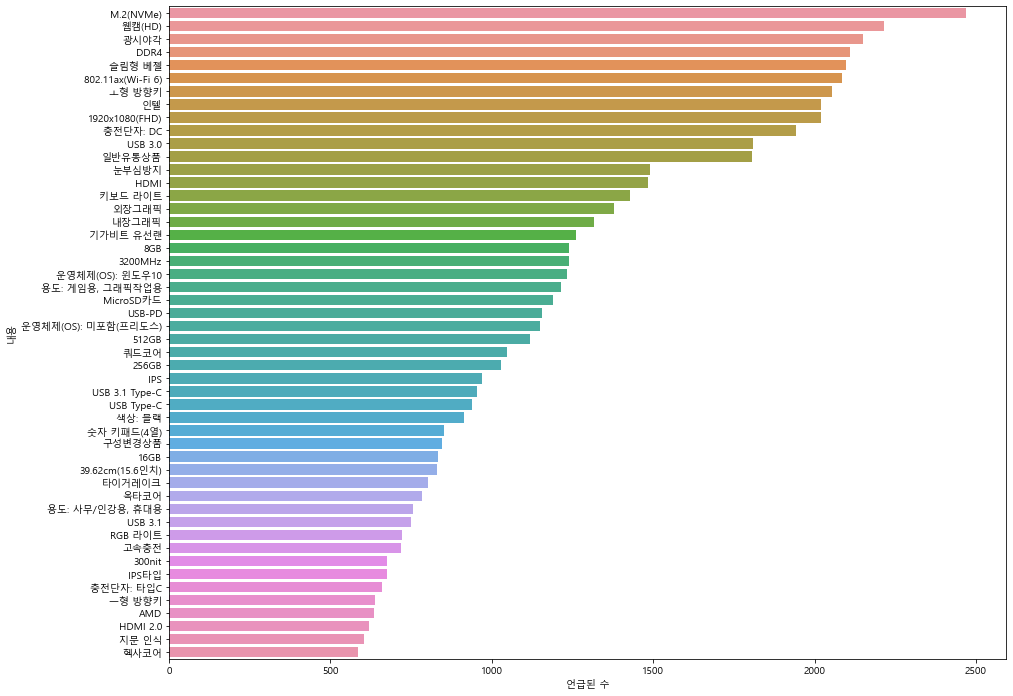

In [230]:
plt.figure(figsize=(15,12))
sns.barplot(x='언급된 수', y='내용', data=notebook_df)

In [233]:
ssd256=[]
ssd1tb=[]

for price in price_list:
    price =price.replace(',' , '')
    try:
        ssd=re.findall('\d*원', price)[0]
    except:
        continue

    if re.match('.*[250-256]GB.*', price):
        ssd256.append(int(ssd.replace('원', '')))
    # elif re.match('.*[500]GB.*', price):
        # ssd512.append(int(ssd.replace('원', '')))
    elif re.match('.*1TB.*', price):
        ssd1tb.append(int(ssd.replace('원', '')))

print('SSD 256GB 전체 노트북의 평균 가격 : %.2f원\n'% np.mean(ssd256))
# print('SSD 512GB 전체 노트북의 평균 가격 : %.2f원'% np.mean(ssd512))
print('SSD 1TB 전체 노트북의 평균 가격 : %.2f원'% np.mean(ssd1tb))


SSD 256GB 전체 노트북의 평균 가격 : 1534924.66원

SSD 1TB 전체 노트북의 평균 가격 : 1763726.24원


## 연습